## PyTorch实现ResNet全系列
用PyTorch实现ResNet，包括ResNet18，ResNet34，ResNet50等

In [69]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [70]:
__all__=['ResNet','resnet18','resnet34','resnet50','resnet101','resnet152']

In [71]:
#添加预训练权重的URL
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

In [72]:
#将卷积层进行一次封装
def conv3x3(in_planes,out_planes,stride=1):
    return nn.Conv2d(in_planes,out_planes,kernel_size=3,stride=stride,padding=1,bias=False)

### 定义Block单元
这里就是这个系列的区别，像resnet18和34这类比较轻小的网络使用的是basic block单元。像50和101这类使用的是BottleBlock这类

#### BasicBlock
基础版的残差模块由两个叠加的3*3卷积组成

In [73]:
class BasicBlock(nn.Module):
    expansion=1
    
    def __init__(self,inplanes,planes,stride=1,downsample=None):
        super(BasicBlock,self).__init__()
        self.conv1=conv3x3(inplanes,planes,stride)
        self.bn1=nn.BatchNorm2d(planes)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=conv3x3(planes,planes)
        self.bn2=nn.BatchNorm2d(planes)
        self.downsample=downsample
        self.stride=stride
    def forward(self,x):
        residual=x#残差单元，就是开始的输入
        
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)
        
        out=self.conv2(out)
        out=self.bn2(out)
        
        if self.downsample is not None:
            residual=self.downsample(x)
        
        out+=residual#就这样实现了残差连接，就这么简单
        out=self.relu(out)
        
        return out

#### Bottleneck
这个模块主要是ResNet50和ResNet101使用的，与基础版本不同的是这里有三个卷积，分别是1x1,3x3,1x1分别用来压缩维度，卷积处理，恢复维度，inplane是输入的通道，plane是输出的通道，expansion是对输出通道数的倍乘，在基础版的这个参数为1则可以忽略不计。输出的就是plane。而在bottleneck它的任务就是对通道数进行压缩，再放大，plane不再代表输出的通道数，而是block内部压缩后的通道数，输出通道变为plane*expansion

In [74]:
class Bottleneck(nn.Module):
    expansion=4
    
    def __init__(self,inplanes,planes,stride=1,downsample=None):
        super(Bottleneck,self).__init__()
        self.conv1=nn.Conv2d(inplanes,planes,kernel_size=1,bias=False)
        self.bn1=nn.BatchNorm2d(planes)
        self.conv2=nn.Conv2d(planes,planes,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn2=nn.BatchNorm2d(planes)
        self.conv3=nn.Conv2d(planes,planes*self.expansion,kernel_size=1,bias=False)
        self.bn3=nn.BatchNorm2d(planes*self.expansion)
        self.relu=nn.ReLU(inplace=True)
        self.downsample=downsample
        self.stride=stride
        
    def forward(self,x):
        residual=x
        
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)
        
        out=self.conv2(out)
        out=self.bn2(out)
        out=self.relu(out)
        
        out=self.conv3(out)
        out=self.bn3(out)
        
        if self.downsample is not None:
            residual=self.downsample(x)
        out+=residual
        out=self.relu(out)
        
        return out

### 定义ResNet网络主体
resnet共有5个阶段，其中第一阶段为7x7的卷积处理，stride为2，然后经过池化处理，此时特征图的尺寸为输入的1/4,接下来四个阶段用make_layer函数产生四个layer，需要用户输入每个layer的block数目以及采用的block类型(基础版还是bottleneck版)

In [97]:
class ResNet(nn.Module):
    
    def __init__(self,block,layers,num_classes=10):
        super(ResNet,self).__init__()
        self.inplaces=64
        self.conv1=nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1=nn.BatchNorm2d(64)
        self.relu=nn.ReLU(inplace=True)
        self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.layer1=self._make_layer(block,64,layers[0])
        self.layer2=self._make_layer(block,128,layers[1],stride=2)
        self.layer3=self._make_layer(block,256,layers[2],stride=2)
        self.layer4=self._make_layer(block,512,layers[3],stride=2)
        self.avgpool=nn.AvgPool2d(7,stride=1)
        self.fc=nn.Linear(512*block.expansion,num_classes)
        #卷积核以及BN的权值初始化
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')#权重初始化
            elif isinstance(m,nn.BatchNorm2d):#BatchNorm2d批规范的初始化
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
                
    def _make_layer(self,block,planes,blocks,stride=1):
        downsample=None
        if stride!=1 or self.inplaces!=planes*block.expansion:
            downsample=nn.Sequential(
                nn.Conv2d(self.inplaces,planes*block.expansion,
                         kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(planes*block.expansion),
            )
        layers=[]
        layers.append(block(self.inplaces,planes,stride,downsample))
        self.inplaces=planes*block.expansion#这里更改inplaces值
        for i in range(1,blocks):
            layers.append(block(self.inplaces,planes))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.maxpool(x)
        
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        
        x=self.avgpool(x)
        x=x.view(x.size(0),-1)
        x=self.fc(x)
        
        return x

In [98]:
def resnet50(pretrained=False,**kwargs):
    model=ResNet(Bottleneck,[3,4,6,3],**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

In [99]:
res=resnet50

### 定义各个模型
包括resnet18,resnet34,resnet50,resnet102

In [100]:
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
#resnet18模型
def resnet18(pretrained=True,**kwargs):
    model=ResNet(BasicBlock,[2,2,2,2],**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['resnet18'],
                                              progress=True)
#         print(state_dict)
        model.load_state_dict(state_dict)
    
#     if pretrained:
        
#         model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model
#resnet34模型
def resnet34(pretrained=False,**kwargs):
    model=ResNet(BasicBlock,[3,4,6,3],**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model
#resnet50模型
def resnet50(pretrained=False,**kwargs):
    model=ResNet(Bottleneck,[3,4,6,3],**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

#resnet101模型
def resnet101(pretrained=False,**kwargs):
    model=ResNet(Bottleneck,[3,4,23,3],**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model
#resnet152模型
def resnet152(pretrained=False,**kwargs):
    model=ResNet(Bottleneck,[3,8,36,3],**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [104]:
import torch
net=resnet50()
inp=torch.rand(1,3,224,224)
out=net(inp)

In [105]:
print(out.size())

torch.Size([1, 10])


In [84]:
img_path=r'/Users/gongpengwang/Documents/advance/Pytorch_tutorial/2020-3-1/hymenoptera_data'

In [52]:
from tqdm import tqdm
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
for root,dirs,files in os.walk(img_path):
  label={'ants':0,'bees':1}
  for file in tqdm(files):
    path_ext=root.split('/')
    if path_ext[-2]=='train':
      with open('train.txt','a+') as f:
        f.write(os.path.join(root,file)+" "+ str(label.get(path_ext[-1]))+'\n')
    else:
      with open('valid.txt','a+') as f:
        f.write(os.path.join(root,file)+" "+ str(label.get(path_ext[-1]))+'\n')

100%|██████████| 70/70 [00:00<00:00, 7330.50it/s]


### 构建自己的数据集类
关键要实现```Datasets```这个类，需要关键实现```__getitem__```和```__len__```方法


1.   制作图片数据的索引
2.   构建Dataset子类


In [40]:
from PIL import Image
from torch.utils.data import Dataset
class MyDatasets(Dataset):
  def __init__(self,txt_path,tranform=None,target_transfomr=None):
    imgs=[]
    with open(txt_path,'r') as f:
      fh=f.readlines()
      for line in fh:
        line=line.rstrip()
        words=line.split(" ")
        print(words)
        if words[1]:
            imgs.append((words[0].replace(" ",""),int(words[1])))
      self.imgs=imgs
      self.transform=tranform
      self.target_transfomr=target_transfomr
  #对每个item的处理
  def __getitem__(self,index):
    fn,label=self.imgs[index]
    img=Image.open(fn).convert("RGB")
    if self.transform is not None:
      img=self.transform(img)
    return img,label
  def __len__(self):
    return len(self.imgs)

In [41]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
normTransform=transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
trainTransform=transforms.Compose([
 transforms.RandomResizedCrop(224),
 transforms.RandomHorizontalFlip(),
 transforms.ToTensor(),
 normTransform                        
])

validTransfrom=transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  normTransform
])

In [42]:
train_data=MyDatasets('train.txt',tranform=trainTransform)
train_loader=DataLoader(train_data,batch_size=4,shuffle=True)

valid_data=MyDatasets('valid.txt',tranform=validTransfrom)
valid_loader=DataLoader(valid_data,batch_size=4,shuffle=False)

['/Users/gongpengwang/Documents/advance/Pytorch_tutorial/2020-3-1/hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg', '1']
['/Users/gongpengwang/Documents/advance/Pytorch_tutorial/2020-3-1/hymenoptera_data/train/bees/507288830_f46e8d4cb2.jpg', '1']
['/Users/gongpengwang/Documents/advance/Pytorch_tutorial/2020-3-1/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg', '1']
['/Users/gongpengwang/Documents/advance/Pytorch_tutorial/2020-3-1/hymenoptera_data/train/bees/2962405283_22718d9617.jpg', '1']
['/Users/gongpengwang/Documents/advance/Pytorch_tutorial/2020-3-1/hymenoptera_data/train/bees/446296270_d9e8b93ecf.jpg', '1']
['/Users/gongpengwang/Documents/advance/Pytorch_tutorial/2020-3-1/hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg', '1']
['/Users/gongpengwang/Documents/advance/Pytorch_tutorial/2020-3-1/hymenoptera_data/train/bees/2704348794_eb5d5178c2.jpg', '1']
['/Users/gongpengwang/Documents/advance/Pytorch_tutorial/2020-3-1/hymenoptera_data/train/bees/2358061370_9daabbd9

## 可视化图片

In [43]:
import matplotlib.pyplot as plt
def imshow(inp,title=None):
    inp=inp.numpy().transpose((1,2,0))
#     inp=inp.numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 
    

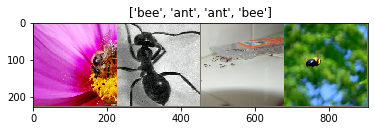

In [44]:
import torchvision
import numpy as np
class_names=["ant","bee"]
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 执行训练

In [62]:

resnet18=resnet50(pretrained=True)
num_ftrs=resnet18.fc.in_features
resnet18.fc=nn.Linear(num_ftrs,2)
criterion=nn.CrossEntropyLoss()
import torch.optim as optim
from torch.optim import lr_scheduler

optimizer_ft=optim.SGD(resnet18.parameters(),lr=0.001,momentum=0.9)
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/gongpengwang/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [09:23<00:00, 182kB/s]   


In [63]:
import time
import copy
import torch
def train_model(model,criterion,optimizer,scheduler,num_epochs=25):
    since=time.time()
    best_model_wts=copy.deepcopy(model.state_dict())
    best_acc=0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print("----"*10)
        running_loss=0.0
        running_corrects=0
        total=0.0#样本的总数
        #训练数据
        for i,data in enumerate(train_loader):
            inputs,labels=data
            device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            model.train()
            inputs,labels=inputs.to(device),labels.to(device)
            #前向传播，后向传播，更新权重
            optimizer.zero_grad()#将要更新的优化器置0，防止后面累加
            with torch.set_grad_enabled(True):
                outputs=model(inputs)
                loss=criterion(outputs,labels)
                _,preds=torch.max(outputs,1)
                loss.backward()#反向传播
                optimizer.step()#学习率更新
                scheduler.step()#更新学习率，在1.0官方建议后学习率更新策略的更新必须放到优化器更新的后面
            running_loss+=loss.item()*inputs.size(0)
            running_corrects+=torch.sum(preds==labels)
            total+=labels.size(0)
        train_loss=running_loss/len(train_loader.dataset)
        train_acc=running_corrects.double()/len(train_loader.dataset)
        print('Training Loss: {:.4f} Acc: {:.4f}'.format(
                train_loss, train_acc))
        loss_sigma=0.0
        valid_correct=0
        for i,data in enumerate(valid_loader):
            model.eval()
            images,labels=data
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss_sigma+=loss.item()*images.size(0)
            _,predicted=torch.max(outputs.data,1)
            valid_correct+=torch.sum(labels==predicted)
        valid_loss=loss_sigma/len(valid_loader.dataset)
        valid_acc=valid_correct.double()/len(valid_loader.dataset)
        print('Valid Loss: {:.4f} Acc: {:.4f}'.format(valid_loss, valid_acc))
        if valid_acc>best_acc:
            best_acc=valid_acc
            best_model_wts=copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model_save_pth='model.pth'
    torch.save(model.state_dict(),model_save_pth)

In [64]:
model_ft=train_model(resnet18,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------------------------------------
Training Loss: 0.6236 Acc: 0.6967
Valid Loss: 0.5699 Acc: 0.8105

Epoch 1/24
----------------------------------------
Training Loss: 0.6135 Acc: 0.6926
Valid Loss: 0.5726 Acc: 0.7908

Epoch 2/24
----------------------------------------
Training Loss: 0.5921 Acc: 0.7705
Valid Loss: 0.5715 Acc: 0.7908

Epoch 3/24
----------------------------------------
Training Loss: 0.5995 Acc: 0.7705
Valid Loss: 0.5752 Acc: 0.7647

Epoch 4/24
----------------------------------------
Training Loss: 0.6255 Acc: 0.6885
Valid Loss: 0.5747 Acc: 0.7843

Epoch 5/24
----------------------------------------
Training Loss: 0.6204 Acc: 0.7459
Valid Loss: 0.5762 Acc: 0.7908

Epoch 6/24
----------------------------------------
Training Loss: 0.6248 Acc: 0.6803
Valid Loss: 0.5740 Acc: 0.7843

Epoch 7/24
----------------------------------------
Training Loss: 0.6040 Acc: 0.7459
Valid Loss: 0.5846 Acc: 0.7582

Epoch 8/24
----------------------------------------
Trai

In [67]:
[2]+[1]

[2, 1]